In [16]:
from typing import Annotated, TypedDict, Optional
from langgraph.graph import StateGraph, START, END, add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
from langchain_core.messages import ToolMessage, HumanMessage
import json

load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [17]:
search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]

memory = MemorySaver()

llm_with_tools = llm.bind_tools(tools)

In [18]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result],
    }


async def tools_router(state: State):
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return "end"


async def tool_node(state: State):
    """Custom tool node that handles tool calls from the LLM"""
    tool_calls = state["messages"][-1].tool_calls

    tool_messages = []
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        if tool_name == "tavily_search_results_json":
            search_results = await search_tool.ainvoke(tool_args)

            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name,
            )

            tool_messages.append(tool_message)

    return {"messages": tool_messages}


graph = StateGraph(State)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges(
    "model", tools_router, {"tool_node": "tool_node", "end": END}
)
graph.add_edge("tool_node", "model")

app = graph.compile(checkpointer=memory)

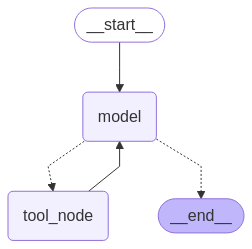

In [19]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [20]:
config = {
    "configurable": {
        "thread_id": 5,
    }
}

response = await app.ainvoke(
    {"messages": [HumanMessage(content="when is the last spacex launch from today")]},
    config=config,
)

response

{'messages': [HumanMessage(content='when is the last spacex launch from today', additional_kwargs={}, response_metadata={}, id='1a369e7e-8fb4-4cb5-b8f7-0a3ab3bcda4b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "last spacex launch date"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-1f6b5ec6-2ce2-4639-ae39-54bfb163f953-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'last spacex launch date'}, 'id': '2bf266e2-4b8b-4e16-82e6-60fd350d01ec', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'output_tokens': 14, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{\'title\': \'List of Falcon 9 and Falcon Heavy launches - Wikipedia\', \'url\': \'https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches

In [21]:
config = {
    "configurable": {
        "thread_id": 6,
    }
}

async for event in app.astream_events(
    {"messages": [HumanMessage(content="Hi my name is Himanshu")]},
    config=config,
    version="v2",
):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

Hello Himanshu, nice to meet you!